## Figures for Precambrian Research Submission - OFP
## **ISOTOPE CONGLOMERATE TESTS**
  
Connor S. van Wieren, 2023

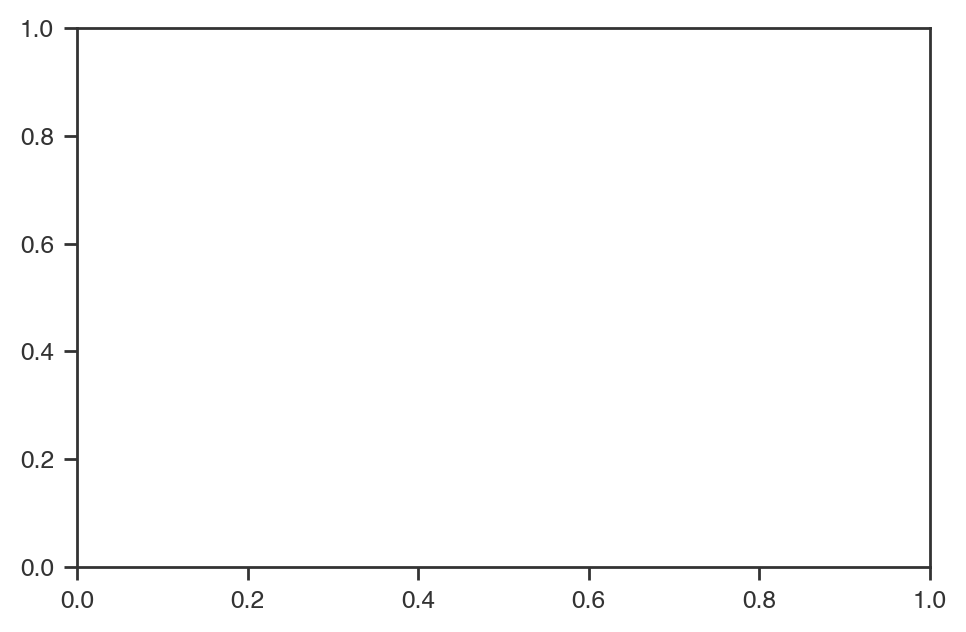

In [2]:
import numpy as np
import numpy.polynomial.polynomial as pl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
import matplotlib.transforms as transforms
from matplotlib import colors
import matplotlib
import pandas as pd
import seaborn as sns
from VanStrat.VanStrat_simple import *
import string
from scipy.ndimage import rotate
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec
import pickle
import dill
import sys
sys.path.insert(0, '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/Useful_Code')
from funcs import *
%matplotlib inline

plt.rcParams['figure.figsize'] = (5.5, 3.5)
%config InlineBackend.figure_format='retina'

sns.set_style('ticks',{'axes.edgecolor':'.3',
                       'xtick.color':'.3',
                       'ytick.color':'.3',
                       'text.color': '.3',
                       'axes.labelcolor':'.3',
                       'axes.grid': False,
                       'grid.linestyle': u'-.'})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

# so that illustrator can read matplotlib fonts
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_colwidth', None)

fig_dir = '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/Publications/OFP_PC/img/'

# load pickle
filename = './pickles/ofp_data.pkl'
dill.load_session(filename)

# read excels
secs = pd.read_excel(home+'./sections/sections_com.xlsx') # sections 
# get rid of secs duplicates
secs = secs.dropna(subset=['d13c_carb']).reset_index(drop=True)

# Lump all Fold limbs for GSM Type into one section
secs.loc[secs['index'].str.contains('GSM Type'),'index'] = 'GSM Type'

clasts = pd.read_excel(home+'./ICTs/icts_com.xlsx') # ICT clasts
nods = pd.read_excel(home+'./hand_samples/nodules.xlsx') # GSM Authigenic Nodules
fans = pd.read_excel(home+'./hand_samples/fans.xlsx') # WMM aragonite fan clasts

# combine clasts and fans
clasts = pd.concat([clasts,fans]).reset_index(drop=True)

In [3]:
# sort by mean d13c value of distributions
s = dict(clasts.groupby('index')['d13c_carb'].mean())
so = {k: v for k, v in sorted(s.items(), key=lambda item: item[1],reverse=False)}
so = list(so.keys())
so

['OFP Landmark',
 'Wolverine',
 'Boomerang',
 'Railway',
 'Redoubt',
 'McKale Creek',
 'GSM Type',
 'Jasper, Highway 16']

In [4]:
# assign unique value for sections with no sample height identifier (Landmark, Redoubt, Highway 16) so easy to count n clasts
clasts.loc[clasts['index']=='Jasper, Highway 16','sample_height'] = 'Hw16'
clasts.loc[clasts['index']=='Redoubt','sample_height'] = 'Red'
clasts.loc[clasts['index']=='OFP Landmark','sample_height'] = 'LM'

In [5]:
## lump certain bed_id's together so that it is easier to see them (Jon says too many colours in boomerang and mckale)
## trying to aim for max 4 per location
clasts['bed_id_lumped'] = clasts['sample_height'].astype(str)

#boomerang
bd = {5.6:'5.6',
      8.6:'5.6',
      11.6:'11.0',
      12.0:'11.0',
      17.0:'17.0',
      65.0:'65.0',
      67.0:'65.0',
      70.0:'65.0'}

# McKale
md = {105.1:'105.0',
     108.0:'108.0',
      110.0:'108.0',
      111.0:'108.0',
      136.0:'136.0',
      139.0:'136.0',
      237.0:'237.0',
      253.2:'253.0',
      256.0:'253.0'}

# wolverine
wd = {96.1:'96.0',
      97.0:'97.0',
      124.2:'124.0',
      143.0:'143.0'}

# combine
tot_d = {**bd,**md,**wd}

# add to df
clasts.loc[clasts['index'].str.contains('Wolverine|McKale|Boomerang'),'bed_id_lumped'] = clasts['sample_height'].map(tot_d)

In [6]:
k='Redoubt'
print(k+'\n____________')
test = []
for i in sorted(set(clasts['bed_id_lumped'][clasts['index']==k])):
    print(i,'; n = ',len(clasts['d13c_carb'][(clasts['bed_id_lumped']==i)&(clasts['index']==k)]))
    test.append(i)
#print(sorted(test))

Redoubt
____________
Red ; n =  96


In [7]:
# count all lumped clasts
clasts['n_clasts_lumped'] = clasts.groupby('bed_id_lumped').bed_id_lumped.transform('count')

In [8]:
# # test figure
# fig,ax=plt.subplots(2,1,figsize=(6,5),layout='constrained')

# for i,j in enumerate(['GSM Type','McKale Creek']):
#     sub = clasts[clasts['index']==j]
    
#     norm = plt.Normalize(vmin=clasts['n_clasts_lumped'].min(),vmax=clasts['n_clasts_lumped'].max())
#     sm = plt.cm.ScalarMappable(cmap='GnBu', norm=norm)
#     # need hue to be clasts and not sub so draws from whole population, sns.histplot has no vmin, vmax 
#     a = sns.histplot(x=sub['d13c_carb'],hue=clasts['n_clasts_lumped'],ax=ax[i],multiple='stack',binwidth=0.3,element='step',stat='count',legend=True,
#                          lw=0.5,alpha=0.8,edgecolor='k',palette='GnBu',cbar=True)
#     plt.colorbar(sm, ax=ax[i])
#     ax[i].set_title(j)
#     ax[i].get_legend().remove()

## Publication Figure

In [9]:
g = sns.color_palette('Greys',n_colors=2).as_hex()
g

['#c6c6c6', '#686868']

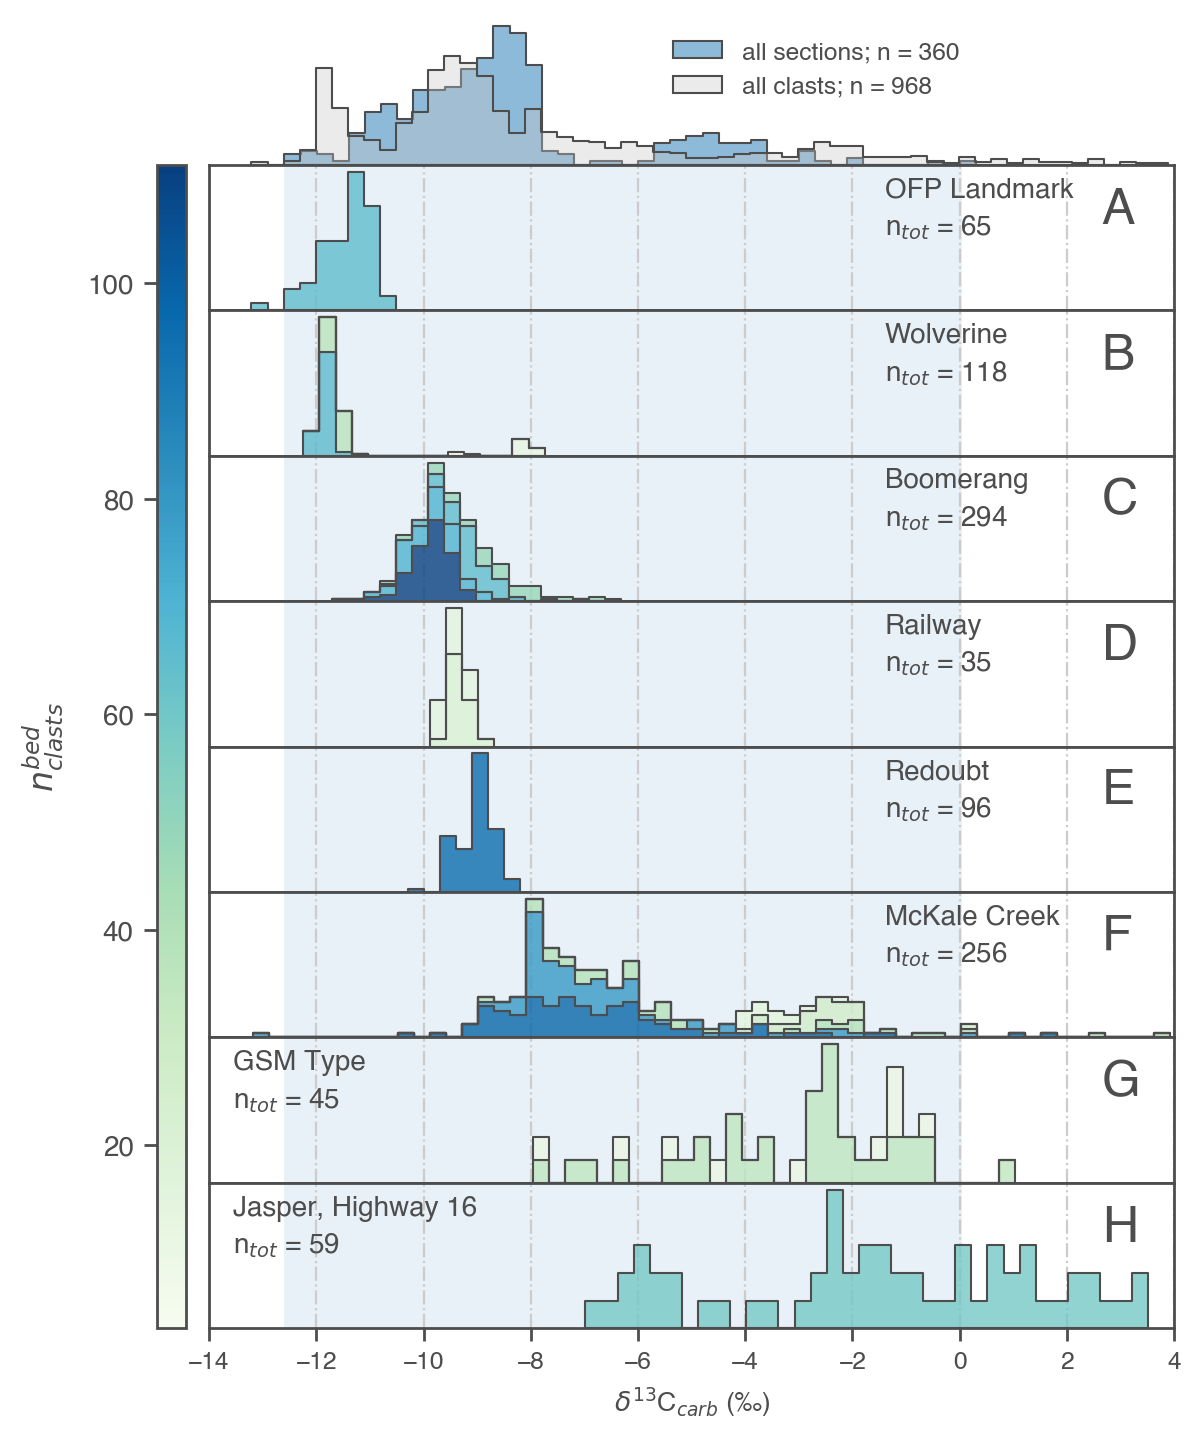

In [9]:
sns.set_context('paper')

lx = len(set(clasts['index']))+1
fig,ax = plt.subplots(lx,1,figsize=(7.5,8.5))
plt.subplots_adjust(hspace=0)

x_targ = 'd13c_carb'
h_pal = 'GnBu'

axs = np.arange(lx)[1:]
axa = np.arange(lx)

# so is sorted index by d13c
# plot all clast data, with seperate beds (hue)

for j,k,bins in zip(axs,so,[.3]*len(so)):
    l = clasts[clasts['index']==k] 
    cmin =  l['n_clasts_lumped'].min()
    cmax =  l['n_clasts_lumped'].max()
    norm = plt.Normalize(cmin, cmax)
    sm = plt.cm.ScalarMappable(cmap=h_pal, norm=norm)
    s = sns.histplot(x=l[x_targ],hue=clasts['n_clasts_lumped'],ax=ax[j],binwidth=bins,multiple='stack',element='step',stat='count',common_norm=False,legend=True,
                 palette=h_pal,lw=0.75,alpha=0.8,edgecolor='.3',zorder=10)
    ax[j].get_legend().remove()
    x=l['d18o_carb']
    y=l['d13c_carb']
    r,_,_,_,ln = linreg(x,y,type='pearson')
    rho,_,_,_,_ = linreg(x,y,type='spearman')
    xt = 0.7 if j in axs[:6] else 0.025
    #ax[j].text(xt,0.3,f'$r$ = {r:.2f}',transform=ax[j].transAxes,fontsize=10) # correlation
    rng = max(y) - min(y)
    #ax[j].text(xt,0.3,f'range = {rng:.1f}‰',transform=ax[j].transAxes,fontsize=10) # correlation
    #ax[j].text(1,.5,f'{rng:.1f}‰',transform=ax[j].transAxes,fontsize=12,rotation=270,va='center') # range


# colorbar
tmin =  clasts['n_clasts_lumped'].min()
tmax =  clasts['n_clasts_lumped'].max()
norm1 = plt.Normalize(tmin, tmax)
sm1 = plt.cm.ScalarMappable(cmap=h_pal, norm=norm1)
ori = 'vertical'
loc = 'top' if ori == 'horizontal' else 'left'
cbar = fig.colorbar(sm1,ax=ax.ravel(),orientation=ori,location=loc,shrink=0.889,aspect=40,pad=0.02,anchor=(1,0)) # shrink=1,aspect=40,pad=0.02
cbar.set_label(label='$n_{clasts}^{bed}$',size=12,labelpad=8)
cbar.ax.tick_params(labelsize=10)
#cbar.ax.set_xticks(np.linspace(tmin,tmax,6))

# clean up ticks
for i in axs:
    ax[i].set_yticks([]) # ticks
    ax[i].set_ylabel(None)
    ax[i].xaxis.grid()
    ax[i].set_xlim(np.floor(clasts[x_targ].min()),np.ceil(clasts[x_targ].max()))

for i in axs[:-1]: 
    ax[i].tick_params(axis='x',length=0)
    ax[i].set_xticklabels([])
    ax[i].set_xlabel(None)
ax[axs[-1]].set_xlabel('$\delta^{13}$C$_{carb}$ (‰)')


labs = [i for i in string.ascii_uppercase[:lx]]
#ax[0].text(0.925,0.6,'A',transform=ax[0].transAxes,fontsize=18,weight='bold') # ABC
for i,j,k in zip(axs,labs,so):
    ax[i].text(0.925,0.6,j,transform=ax[i].transAxes,fontsize=18,weight='bold') # ABC
    xt = 0.7 if i in axs[:6] else 0.025
    ax[i].text(xt,0.78,k,transform=ax[i].transAxes,fontsize=10,weight='bold') # locality
    num = len(clasts[x_targ][clasts['index']==k])
    ax[i].text(xt,0.52,'n$_{tot}$ = '+f'{num}',transform=ax[i].transAxes,fontsize=10) # sample size

# add various comparison populations
sec_c = secs[x_targ]
fan_c = fans[x_targ]
nod_c = nods[x_targ]
clast_c = clasts[x_targ]

for i in axs:
    for j,c,l in zip([sec_c],['C0'],['sec']):
        ax[i].axvspan(j.min(),j.max(),color=c,zorder=0,alpha=0.1,label=l,lw=0) # add bins so lines up with the histogram
        #ax[i].axvspan(j.max(),ax[i].get_ylim()[1],color='tab:red',zorder=0,alpha=0.075,label='eroded',lw=0)
        #ax[i].axvline(j.max(),color='k',zorder=0,alpha=0.25,label='eroded',ls='--')

# new axis on top - clast and section distributions
pal = sns.color_palette(h_pal,n_colors=10).as_hex()
ax[0].sharex(ax[1])
ax[0].axis('off')

sns.histplot(x=sec_c,ax=ax[0],binwidth=bins,color='C0',multiple='stack',element='step',stat='density',common_norm=False,legend=True,
              lw=0.75,alpha=0.5,edgecolor='.3',zorder=10,label=f'all sections; n = {len(secs)}')
sns.histplot(x=clast_c,ax=ax[0],binwidth=bins,color=g[0],multiple='stack',element='step',stat='density',common_norm=False,legend=True,
              lw=0.75,alpha=0.35,edgecolor='.3',zorder=10,label=f'all clasts; n = {len(clasts)}')
ax[0].legend(frameon=False,bbox_to_anchor=(0.8,1))

fig.savefig(fig_dir+'ict_stack.pdf',format='pdf',bbox_inches='tight',transparent=True)

## Version for Exit Seminar

In [40]:
clasts.columns

Index(['index', 'member', 'sample_name', 'sample_height', 'sample_facies',
       'sample_features', 'sample_facies_simplified', 'sample_lith',
       'trace_facies', 'length_cm', 'width_cm', 'colour', 'd13c_carb',
       'd18o_carb', 'id', 'clast_len_cm', 'clast_width_cm',
       'min_drildist_from_matrix_mm', 'Li_umol_molCa', 'Na_mmol_molCa',
       'Mg_mmol_molCa', 'Al_mmol_molCa', 'K_mmol_molCa', 'V_umol_molCa',
       'Mn_mmol_molCa', 'Fe_mmol_molCa', 'Rb_umol_molCa', 'Sr_mmol_molCa',
       'Th_umol_molCa', 'U_umol_molCa', 'Beam Area', 'facies', 'bed_id_lumped',
       'n_clasts_lumped'],
      dtype='object')

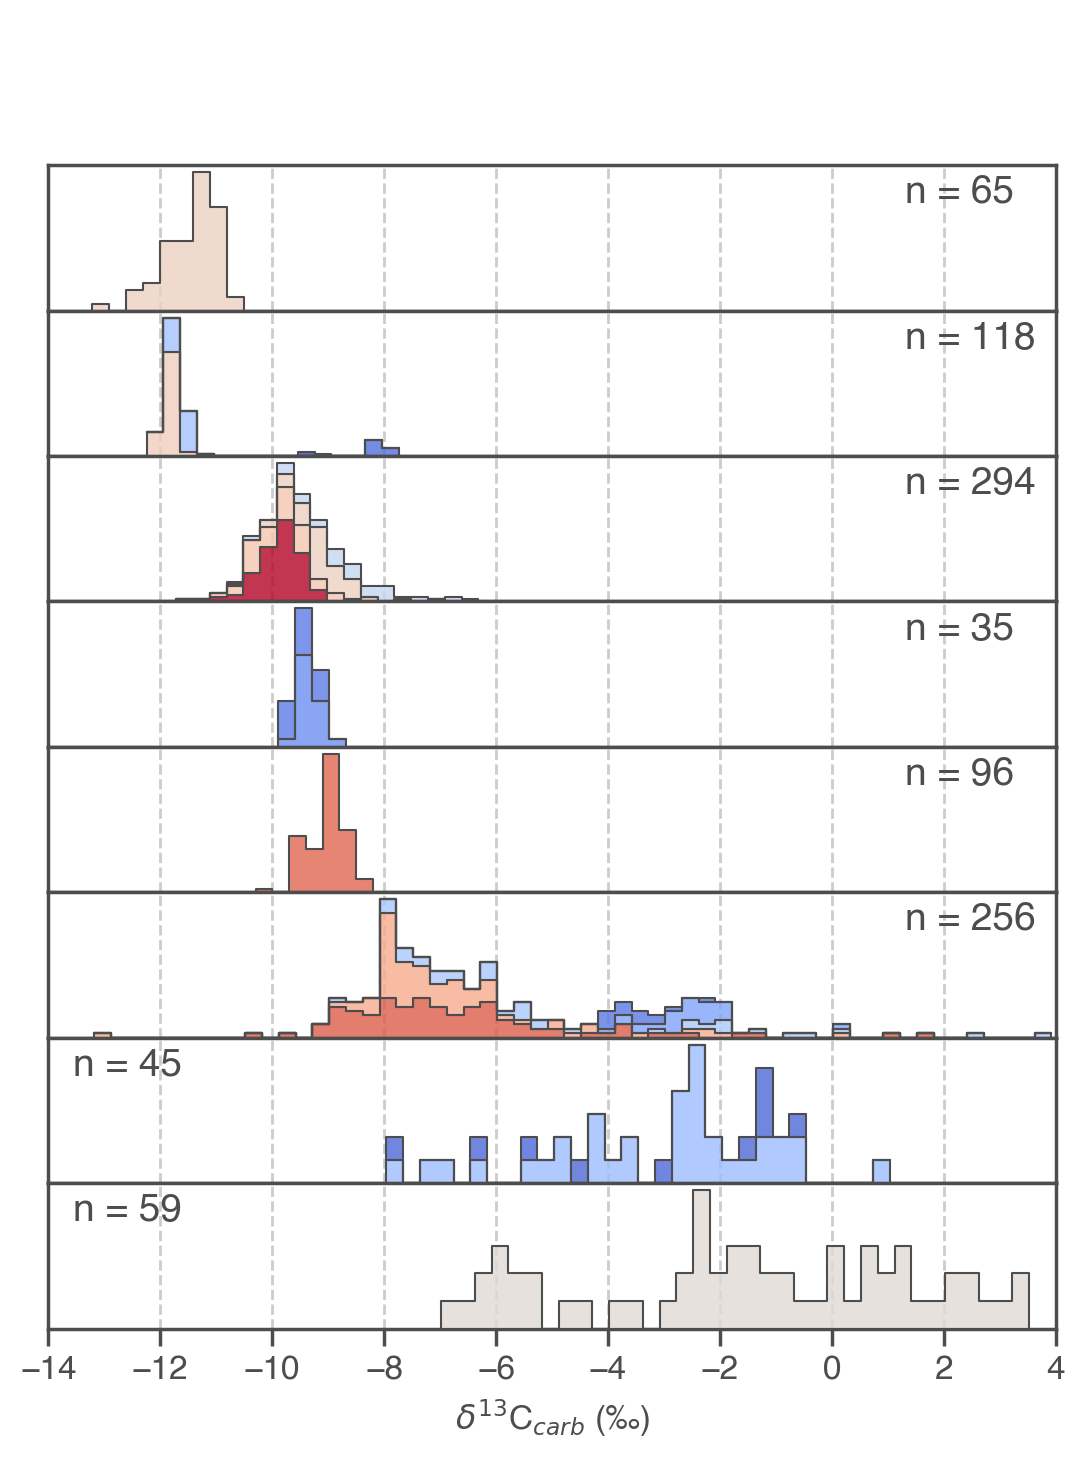

In [65]:
sns.set_context('notebook')

lx = len(set(clasts['index']))+1
fig,ax = plt.subplots(lx,1,figsize=(6.5,8.5))
plt.subplots_adjust(hspace=0)

x_targ = 'd13c_carb'
h_pal = 'coolwarm'

axs = np.arange(lx)[1:]
axa = np.arange(lx)

# so is sorted index by d13c
# plot all clast data, with seperate beds (hue)

for j,k,bins in zip(axs,so,[.3]*len(so)):
    l = clasts[clasts['index']==k] 
    # sm = plt.cm.ScalarMappable(cmap=h_pal, norm=norm)
    # s = sns.histplot(x=l[x_targ],ax=ax[j],color='tab:orange',binwidth=bins,element='step',stat='count',common_norm=False,legend=True,
    #              lw=0.75,alpha=0.6,edgecolor='.3',zorder=10)

    # version with layer colours
    cmin =  l['n_clasts_lumped'].min()
    cmax =  l['n_clasts_lumped'].max()
    norm = plt.Normalize(cmin, cmax)
    sm = plt.cm.ScalarMappable(cmap=h_pal, norm=norm)
    s = sns.histplot(x=l[x_targ],hue=clasts['n_clasts_lumped'],ax=ax[j],binwidth=bins,multiple='stack',element='step',stat='count',common_norm=False,legend=True,
                 palette=h_pal,lw=0.75,alpha=0.8,edgecolor='.3',zorder=10)
    ax[j].get_legend().remove()

    x=l['d18o_carb']
    y=l['d13c_carb']



# colorbar
# tmin =  clasts['n_clasts_lumped'].min()
# tmax =  clasts['n_clasts_lumped'].max()
# norm1 = plt.Normalize(tmin, tmax)
# sm1 = plt.cm.ScalarMappable(cmap=h_pal, norm=norm1)
# ori = 'vertical'
# loc = 'top' if ori == 'horizontal' else 'left'
# cbar = fig.colorbar(sm1,ax=ax.ravel(),orientation=ori,location=loc,shrink=0.889,aspect=40,pad=0.02,anchor=(1,0)) # shrink=1,aspect=40,pad=0.02
# cbar.set_label(label='$n_{clasts}^{bed}$',size=14,labelpad=8)
# cbar.ax.tick_params(labelsize=12)

# clean up ticks
for i in axs:
    ax[i].set_yticks([]) # ticks
    ax[i].set_ylabel(None)
    ax[i].xaxis.grid(ls='--')
    ax[i].set_xlim(np.floor(clasts[x_targ].min()),np.ceil(clasts[x_targ].max()))

for i in axs[:-1]: 
    ax[i].tick_params(axis='x',length=0)
    ax[i].set_xticklabels([])
    ax[i].set_xlabel(None)
ax[axs[-1]].set_xlabel('$\delta^{13}$C$_{carb}$ (‰)',fontsize=12)
ax[axs[-1]].tick_params(axis='x',labelsize=12)


labs = [i for i in string.ascii_uppercase[:lx]]
for i,j,k in zip(axs,labs,so):
    xt = 0.85 if i in axs[:6] else 0.025
    #ax[i].text(xt,0.78,k,transform=ax[i].transAxes,fontsize=12,weight='bold') # locality
    num = len(clasts[x_targ][clasts['index']==k])
    ax[i].text(xt,0.74,'n = '+f'{num}',transform=ax[i].transAxes,fontsize=14) # sample size

# add various comparison populations
sec_c = secs[x_targ]
fan_c = fans[x_targ]
nod_c = nods[x_targ]
clast_c = clasts[x_targ]

# for i in axs:
#     for j,c,l in zip([sec_c],['C0'],['sec']):
#         ax[i].axvspan(j.min(),j.max(),color=c,zorder=0,alpha=0.1,label=l,lw=0) # add bins so lines up with the histogram
      
# new axis on top - clast and section distributions
# pal = sns.color_palette(h_pal,n_colors=10).as_hex()
# ax[0].sharex(ax[1])
ax[0].axis('off')

# sns.histplot(x=sec_c,ax=ax[0],binwidth=bins,color='C0',multiple='stack',element='step',stat='density',common_norm=False,legend=True,
#               lw=0.75,alpha=0.5,edgecolor='.3',zorder=10,label=f'all sections; n = {len(secs)}')
# sns.histplot(x=clast_c,ax=ax[0],binwidth=bins,color=g[0],multiple='stack',element='step',stat='density',common_norm=False,legend=True,
#               lw=0.75,alpha=0.35,edgecolor='.3',zorder=10,label=f'all clasts; n = {len(clasts)}')
# ax[0].legend(frameon=False,bbox_to_anchor=(0.8,1))

fig_dir = '/Users/cvanwieren/Library/CloudStorage/Dropbox/GitHub/Talks/UVic_Department_Talks/Exit Seminar/img/ofp_icts/'

fig.savefig(fig_dir+'ict1.png',format='png',dpi=300,bbox_inches='tight',transparent=True)

## Individual locality plots

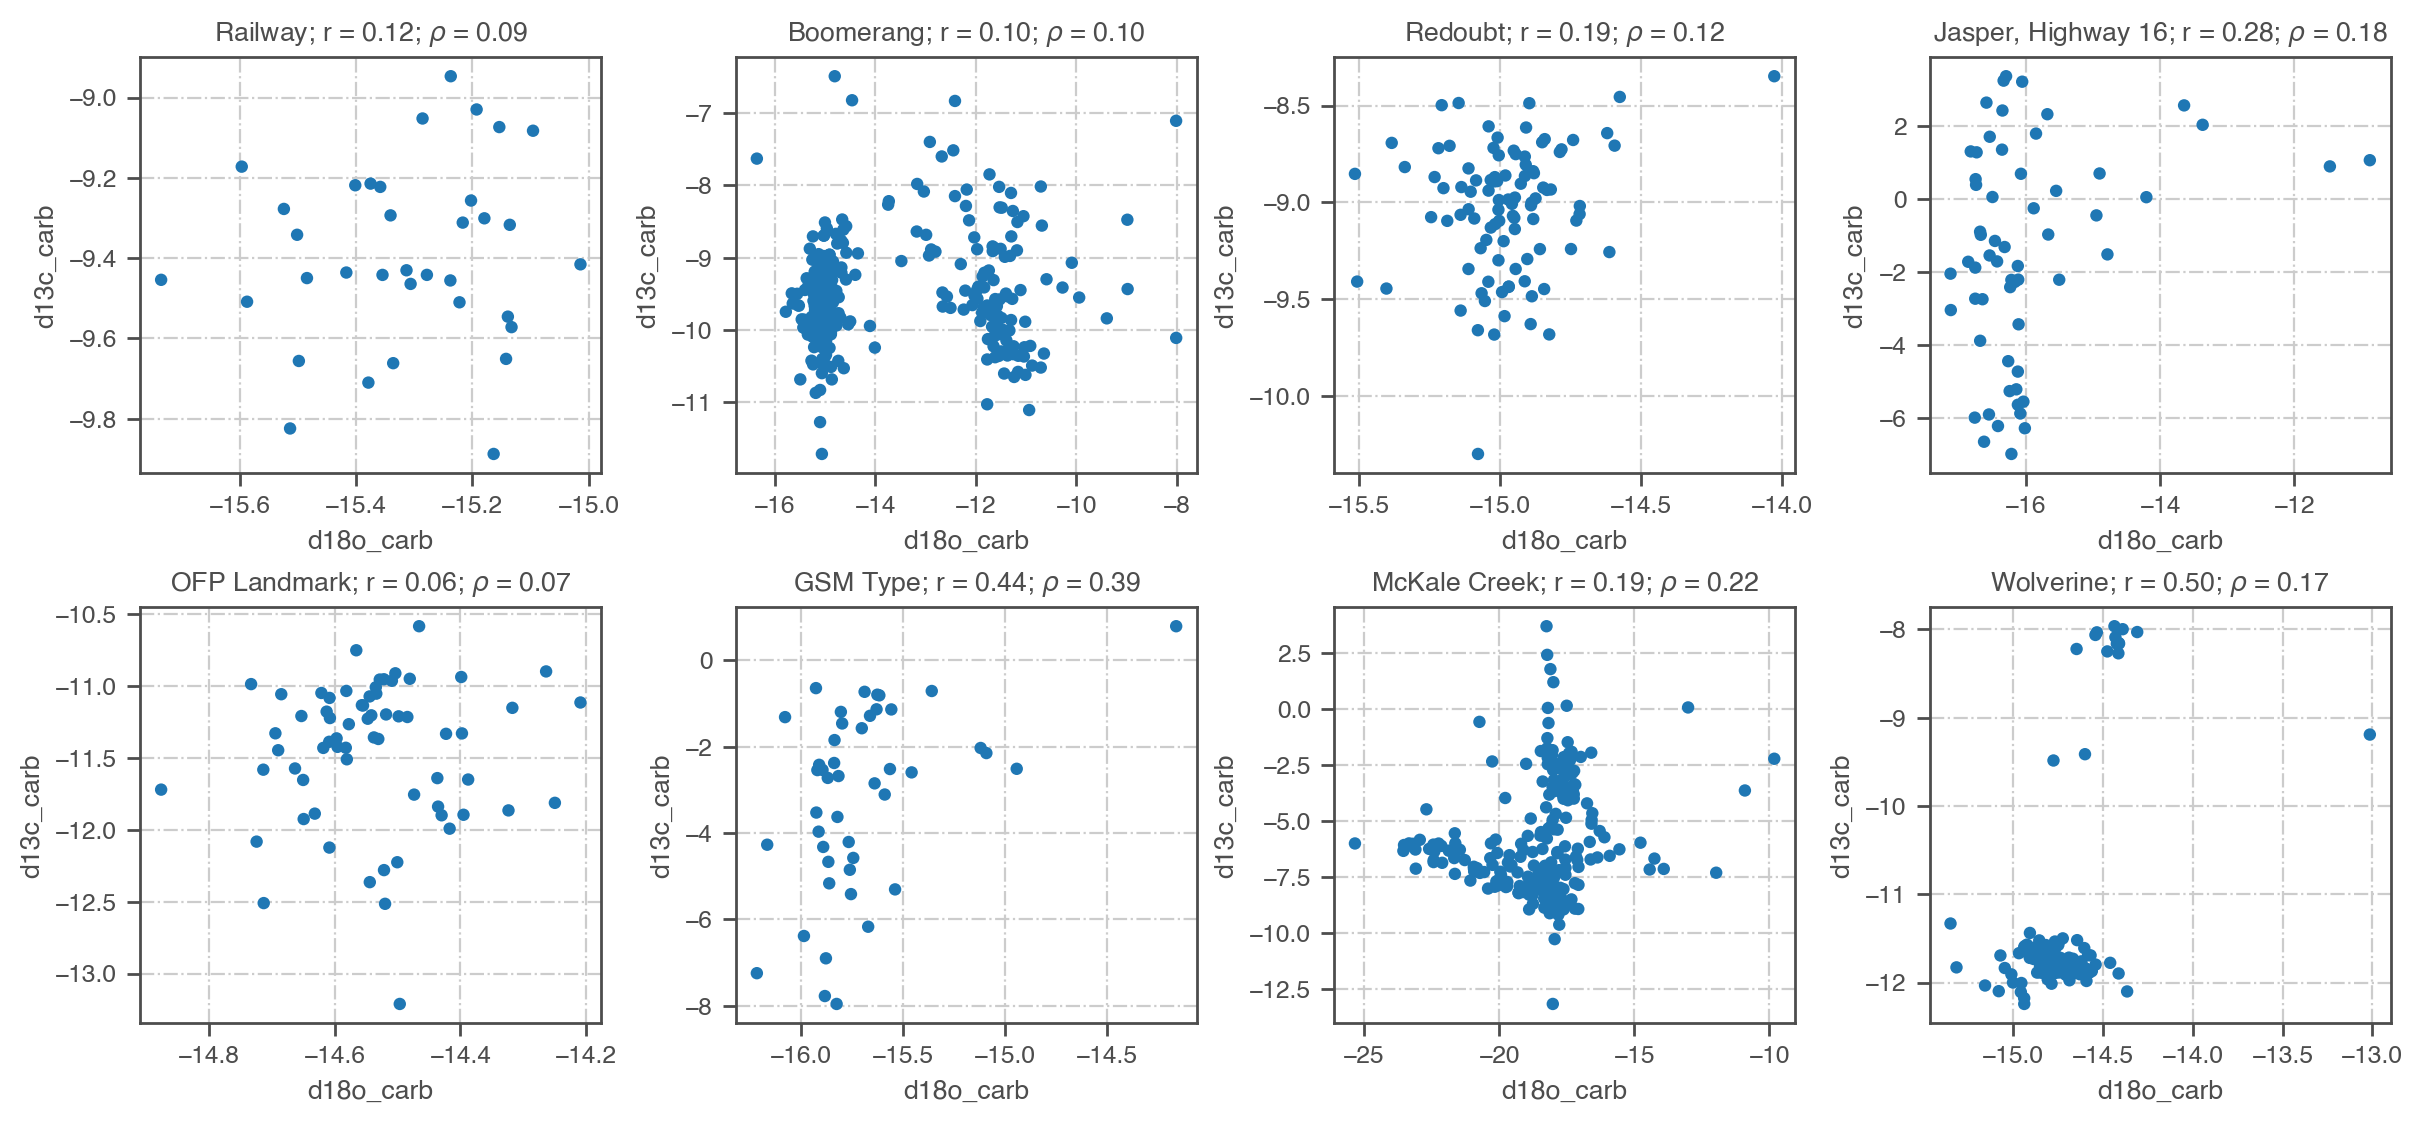

In [10]:
fig,ax = plt.subplot_mosaic(
    """
    abcd
    efgh
    """,figsize=(12,5.5),sharey=False,layout='constrained')
axs = list(ax.keys())

for a,i in zip(axs,set(clasts['index'])):
    sub = clasts[clasts['index']==i]
    sns.scatterplot(data=sub,x='d18o_carb',y='d13c_carb',ax=ax[a],edgecolor='none',s=20)
    ax[a].grid()
    x = sub['d18o_carb']
    y = sub['d13c_carb']
    r,_,_,_,ln = linreg(x,y,type='pearson')
    rho,_,_,_,_ = linreg(x,y,type='spearman')
    l = f'{i}; r = {r:.2f}; $\\rho$ = {rho:.2f}'
    ax[a].set_title(l)

## Breccia Thickness vs $\delta^{13}$C

In [11]:
# beds = set(clasts['sample_height'])
# print(len(beds))
# beds

In [12]:
# all ict beds {bed_id:thickness}, see igc sticker notebook nov 17, 23
brec_thick = {105.1:1.8,
              108.0:1.0,
              11.6:4.0,
              110.0:0.8,
              111.0:2.0,
              12.0:4.0,
              124.2:0.5,
              136.0:1.0,
              139.0:1.5,
              143.0:0.6,
              17.0:7.0,
              171.0:2.8,
              190.5:2.4,
              237.0:1.4,
              253.2:np.nan, # 4.1, # was in succession of interbedded cgl and lsms so honestly meaningless
              256.0:0.8,
              4.5:0.3,
              5.6:5.0,
              5.9:1.0,
              65.0:1.5,
              67.0:2.4,
              70.0:1.6,
              8.6:5.0,
              96.1:0.3,
              97.0:0.4,
              'Hw16':1.8, # was first one so approximating here as no section, only measured ict1 - still good data
              'LM':18.5, # minimum as top and bottom covered
              'Red':np.nan} # no possible measurement, no exposure

clasts['brec_thick'] = clasts['sample_height'].map(brec_thick)

### Plot
- need to think of a metric for comparing these, maybe mean d13c? or just boxplot it and sort by breccia thickness?
- excluding intraclast breccias and questionable data (minimums are ok, but the interbedded muds one is meaningless)

/var/folders/ss/pfgdfm2x7_s4cyw2v0b_t7q80000gn/T/ipykernel_27432/3095587750.py:7: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(data=sub,x=x,y=targ,palette=pal,size=7,jitter=True,alpha=0.8,zorder=0)


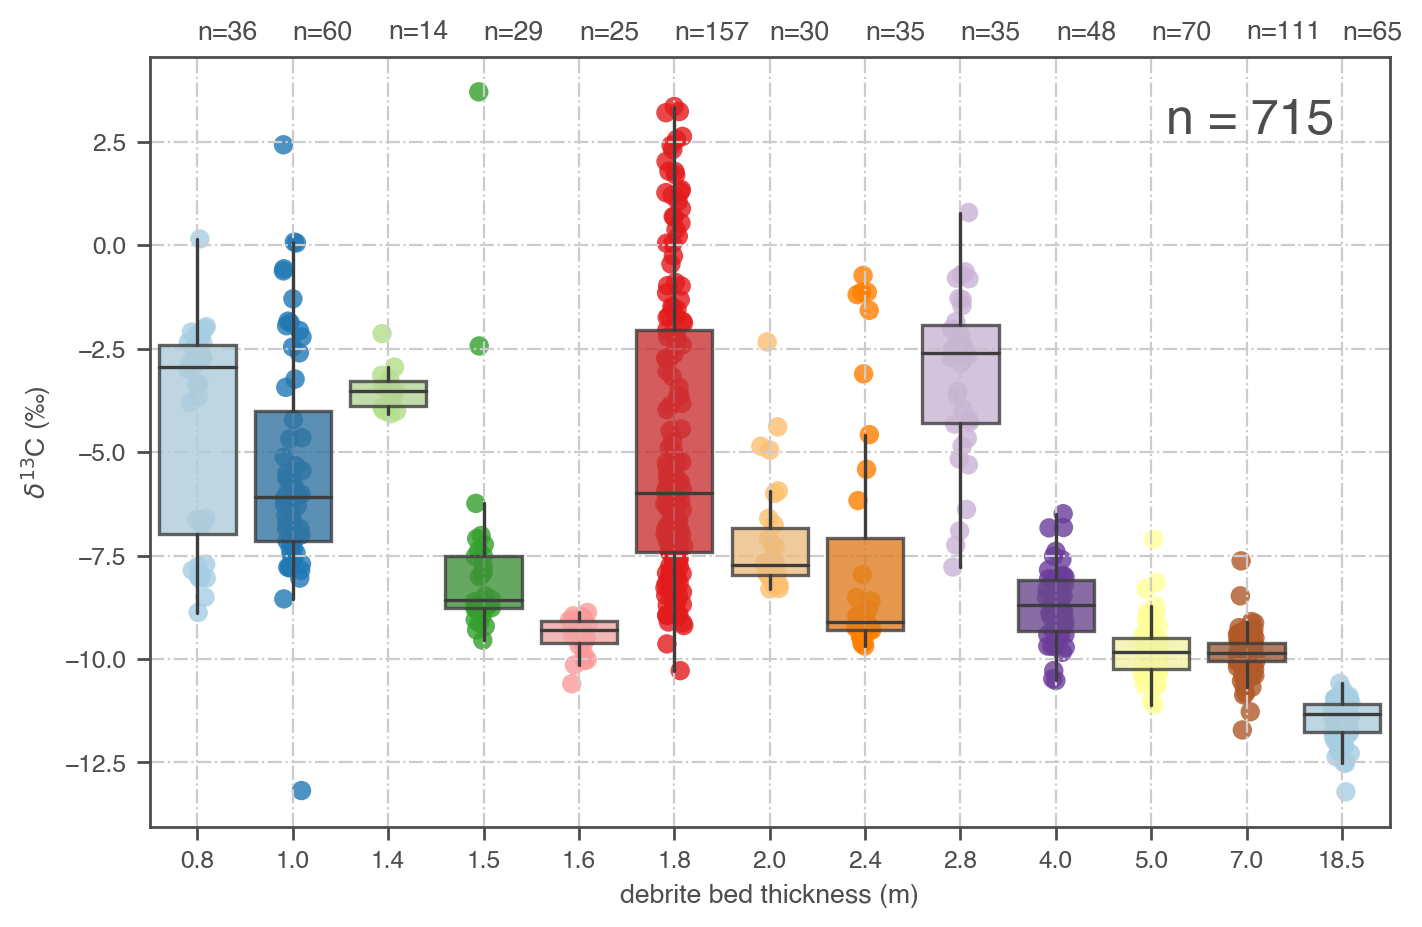

In [13]:
sub = clasts[~clasts['index'].str.contains('Wolverine|Railway|Redoubt')].dropna(subset=['brec_thick']).reset_index(drop=True)

fig,ax = plt.subplots(figsize=(8,5))
pal='Paired'
targ = 'd13c_carb'
x = 'brec_thick'
sns.stripplot(data=sub,x=x,y=targ,palette=pal,size=7,jitter=True,alpha=0.8,zorder=0)
sns.boxplot(data=sub,x=x,y=targ,ax=ax,palette=pal,showfliers=False,flierprops=dict(marker='o'),
            capprops=dict(linewidth=0),boxprops=dict(alpha=0.8),showmeans=False,meanprops=dict(marker='s',markerfacecolor='.3',alpha=0.8,mec='.3',markersize=6))

counts = sub[x].value_counts().sort_index().values

ax.grid()
ax.set_xlabel('debrite bed thickness (m)')
ax.set_ylabel('$\delta^{13}$C (‰)')
# label sample size total
ax.text(0.82,0.9,f'n = {len(sub)}',transform=ax.transAxes,fontsize=18)

for i,c in zip(ax.get_xticks(),counts):
    ax.text(i,5,f'n={c}')

In [14]:
sub['brec_thick'].describe()

count    715.000000
mean       4.528671
std        4.862799
min        0.800000
25%        1.800000
50%        2.400000
75%        5.000000
max       18.500000
Name: brec_thick, dtype: float64

In [15]:
clasts.groupby(by=['index'])['brec_thick'].describe()

,count,mean,std,min,25%,50%,75%,max
index,,,,,,,,
Boomerang,294.0,4.903061,1.964695e+00,1.5,4.0,5.0,7.0,7.0
GSM Type,45.0,2.711111,1.681750e-01,2.4,2.8,2.8,2.8,2.8
"Jasper, Highway 16",59.0,1.800000,2.015555e-15,1.8,1.8,1.8,1.8,1.8
McKale Creek,252.0,1.451587,4.396185e-01,0.8,1.0,1.8,1.8,2.0
OFP Landmark,65.0,18.500000,0.000000e+00,18.5,18.5,18.5,18.5,18.5
Railway,35.0,0.700000,3.514675e-01,0.3,0.3,1.0,1.0,1.0
Redoubt,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wolverine,118.0,0.366949,9.433083e-02,0.3,0.3,0.3,0.4,0.6


In [16]:
clasts.groupby(by=['index'])['d13c_carb'].describe()

,count,mean,std,min,25%,50%,75%,max
index,,,,,,,,
Boomerang,294.0,-9.506697,0.745385,-11.714916,-9.956052,-9.592191,-9.119042,-6.488633
GSM Type,45.0,-3.182931,2.115913,-7.959247,-4.576724,-2.595354,-1.462225,0.790444
"Jasper, Highway 16",59.0,-1.466140,2.902074,-6.979259,-3.238166,-1.520405,0.790074,3.353618
McKale Creek,256.0,-5.867304,2.525811,-13.179506,-7.768025,-6.643711,-3.903308,3.708195
OFP Landmark,65.0,-11.452828,0.493606,-13.210600,-11.755273,-11.332605,-11.083094,-10.584627
Railway,35.0,-9.389264,0.223291,-9.887455,-9.509180,-9.430178,-9.239537,-8.947008
Redoubt,96.0,-9.032711,0.332941,-10.297138,-9.240294,-8.986113,-8.814292,-8.348774
Wolverine,118.0,-11.344495,1.166130,-12.241222,-11.876112,-11.758104,-11.596402,-7.963058


In [17]:
clasts.groupby(by=['index'])['d18o_carb'].describe()

,count,mean,std,min,25%,50%,75%,max
index,,,,,,,,
Boomerang,294.0,-13.672717,1.800906,-16.360264,-15.072513,-14.846249,-11.763757,-8.012815
GSM Type,45.0,-15.700321,0.344167,-16.215372,-15.881967,-15.797110,-15.624710,-14.159636
"Jasper, Highway 16",59.0,-15.968443,1.169962,-17.124596,-16.607046,-16.243326,-16.027604,-10.877118
McKale Creek,256.0,-18.496249,1.926776,-25.339485,-19.028430,-18.108617,-17.621539,-9.817889
OFP Landmark,65.0,-14.538118,0.122698,-14.876460,-14.608816,-14.541818,-14.480567,-14.208823
Railway,35.0,-15.315669,0.165726,-15.735349,-15.409039,-15.306163,-15.185904,-15.013940
Redoubt,96.0,-14.975954,0.200518,-15.514109,-15.071069,-14.982507,-14.886053,-14.028140
Wolverine,118.0,-14.733889,0.243144,-15.349609,-14.849325,-14.767262,-14.640506,-13.013906


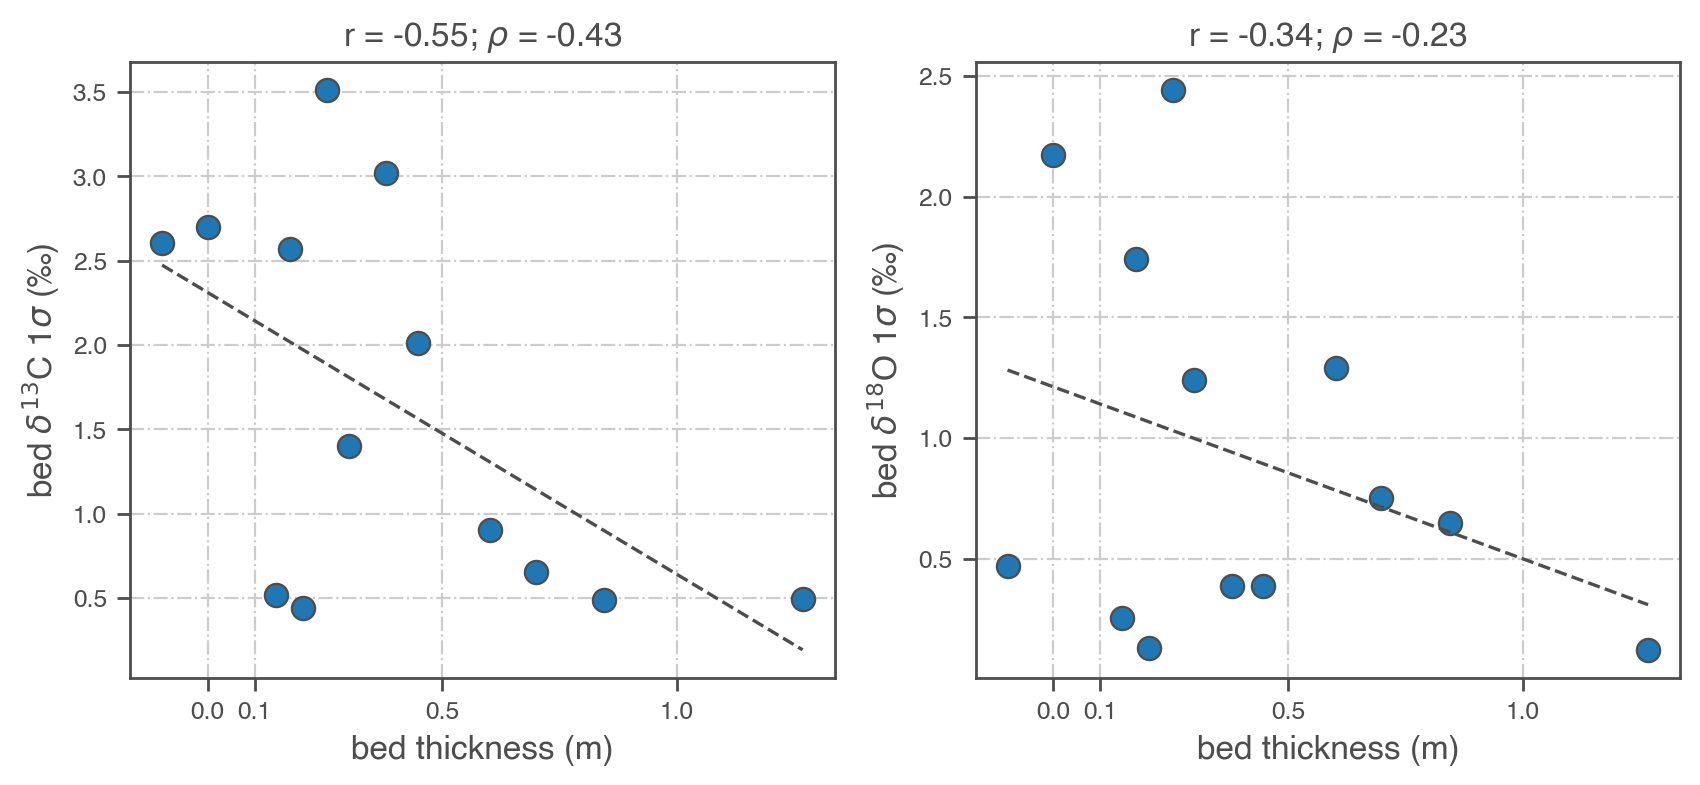

In [18]:
fig,ax = plt.subplots(1,2,figsize=(10,4),sharex=True)

#sub = sub[sub['brec_thick']<18]

targ = 'd13c_carb'
targ1 = 'd18o_carb'
y = sub.groupby(by=['brec_thick'])[targ].std().values
z = sub.groupby(by=['brec_thick'])['Sr_mmol_molCa'].std().values
x = sub.groupby(by=['brec_thick'])[targ].std().index
x = np.log10(x)

y1 = sub.groupby(by=['brec_thick'])[targ1].std().values
z1 = sub.groupby(by=['brec_thick'])['Sr_mmol_molCa'].std().values
x1 = sub.groupby(by=['brec_thick'])[targ1].std().index
x1 = np.log10(x1)

s = ax[0].scatter(x=x,y=y,s=70,edgecolor='.3')
#plt.colorbar(s,label='Sr/Ca (mmol/mol)')
ax[0].grid()
ax[0].set_ylabel('bed $\delta^{13}$C 1$\sigma$ (‰)',fontsize=12)
ax[0].set_xlabel('bed thickness (m)',fontsize=12)

s1 = ax[1].scatter(x=x1,y=y1,s=70,edgecolor='.3')
#plt.colorbar(s1,label='Sr/Ca (mmol/mol)')
ax[1].grid()
ax[1].set_ylabel('bed $\delta^{18}$O 1$\sigma$ (‰)',fontsize=12)
ax[1].set_xlabel('bed thickness (m)',fontsize=12)

# format ticks for log and actual values
ticks_x = FuncFormatter(lambda x, pos: '{0:g}'.format(round(10**x,2)))
# ax[0].xaxis.set_major_formatter(ticks_x)
# ax[1].xaxis.set_major_formatter(ticks_x)

# regression C - these include the 18.5 thick ones 
r,_,_,_,ln = linreg(x,y,type='pearson')
rho,_,_,_,_ = linreg(x,y,type='spearman')
l = f'r = {r:.2f}; $\\rho$ = {rho:.2f}'
ax[0].set_title(l, fontsize=12)
ax[0].plot(ln[0],ln[1],ls='--',color='.3')

# regression O
r1,_,_,_,ln1 = linreg(x1,y1,type='pearson')
rho1,_,_,_,_ = linreg(x1,y1,type='spearman')
l1 = f'r = {r1:.2f}; $\\rho$ = {rho1:.2f}'
ax[1].set_title(l1, fontsize=12)
ax[1].plot(ln1[0],ln1[1],ls='--',color='.3')

for a in [0,1]:
    ax[a].set_xticks([0,.1,0.5,1])

# 